# Each of the markdown sections below will be a separate code file (function notebook)

In [1]:
## put all the modules we have used up here possibly (numpy,matplotlib, etc)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import csv
import numpy as np

import random
import itertools

from collections import defaultdict
from sklearn.model_selection import train_test_split

In [2]:
## this imports all the functions in the corresponding code file

%run image_preprocessing.ipynb

In [3]:
## Set the folder path for the balanced dataset
## set the filename for the balanced data csv file


# Folder containing the image files and the corresponding CSV file
folder_path = "Glaucoma_Balanced_Dataset/JustRAIGS"
csv_file = "JustRAIGS_Train_labels_balance_3000_images.csv"
csv_path = os.path.join(folder_path,csv_file)
print(csv_path)

# Read the CSV file containing the image filenames and classifications
data = pd.read_csv(csv_path)


Glaucoma_Balanced_Dataset/JustRAIGS\JustRAIGS_Train_labels_balance_3000_images.csv


## do the preprocessing on the balanced dataset (cropping & resizing, hist eq, normalization) [possibly repeat this step and break it into 2 steps for the ability to upload on github)

if we include cropping in this step, we can just output the final cropped images, and this may keep us below the github 2 gb limit

In [4]:
# Specify the desired output size (e.g., 1956 x 1725)
target_width = 2048
target_height = 1024

#The number of images will be randomly shuffled through and images can't be selected twice (not put back)
num_images = 10


# Process images and get a list of processed images (as NumPy arrays)
processed_images = process_images_from_csv(data, folder_path, target_width, target_height, num_images)

# Print the number of processed images (just for testing purposes)
print(f"Number of processed images: {len(processed_images)}")

Number of processed images: 10


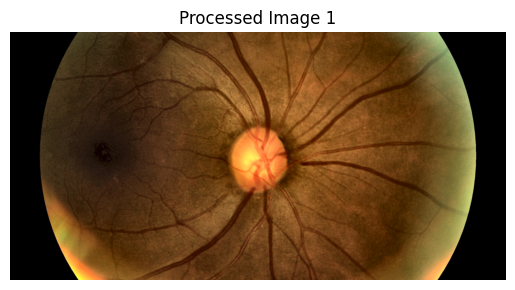

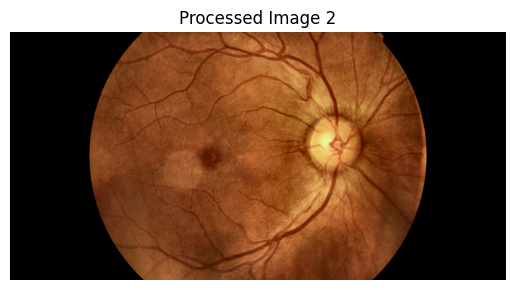

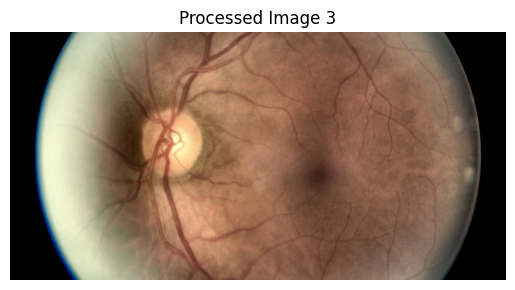

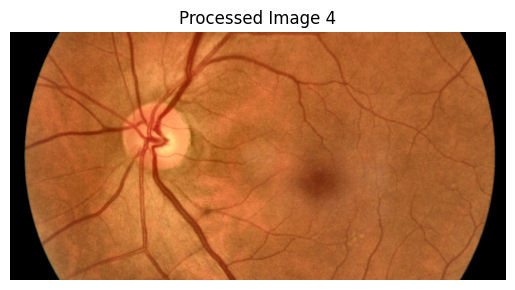

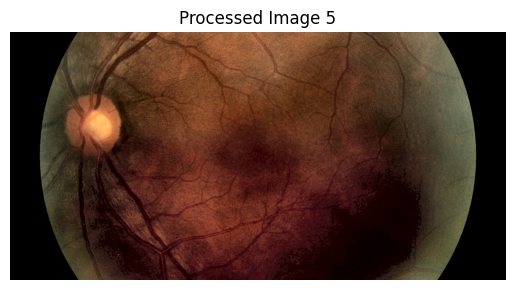

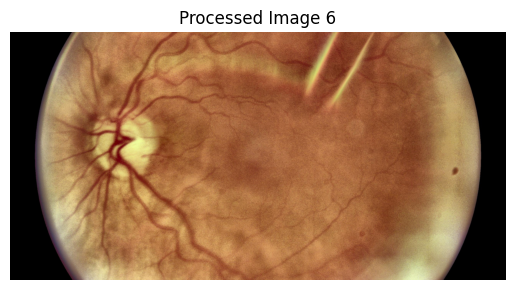

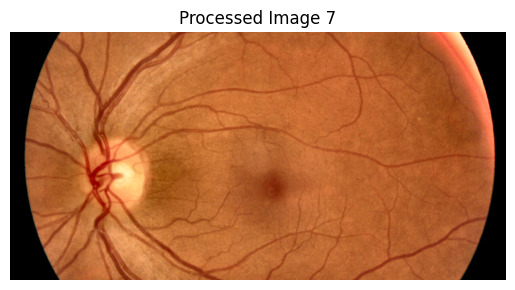

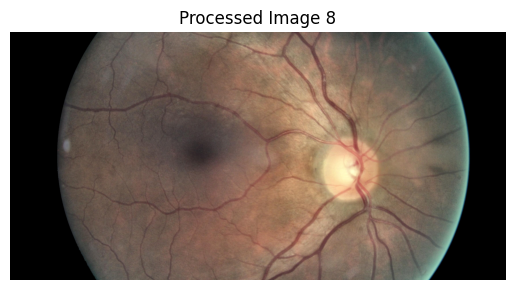

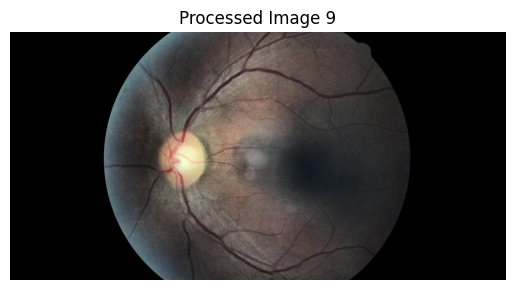

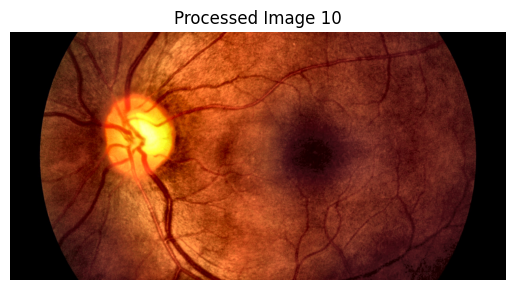

In [5]:
## For testing purposes only
##ONLY RUN THIS FOR LESS THAN 15 IMAGES, IT WILL DISPLAY ALL THE IMAGES

##This code block will be useful in applying this output later for the FCN step if we want


# Example: Access and work with the processed images
for idx, img_array in enumerate(processed_images):
    # Convert BGR to RGB (assuming img_array is in BGR format)
    image_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

    # Display the processed image using matplotlib
    plt.imshow(image_rgb)
    plt.title(f"Processed Image {idx + 1}")  # Set title
    plt.axis('off')  # Turn off axis
    plt.show()


## Train the FCN (these images were already preprocessed and bounded using Label Studio (Just run the output of Diana's code with this block, so that we get the trained network out)

This might be 2 separate FCNs with the same architecture, or one that can train on both
2 separate identical is easier to code

In [6]:
#Apply the FCN to the rest of the dataset

## Apply the saved model to the rest of the dataset for the ROI

1/1 [==============================] - 0s 16ms/step


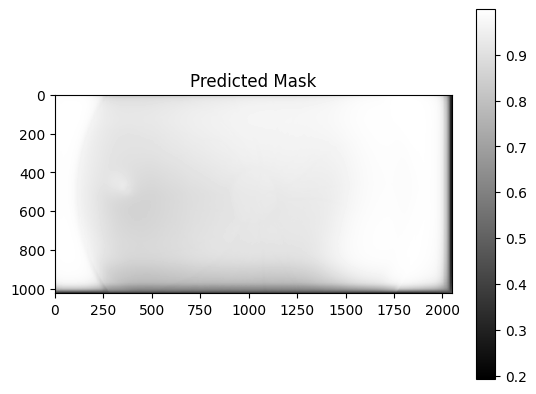

In [7]:
# Load the saved model
#loaded_model = tf.keras.models.load_model("ROI_model.h5")
loaded_model = tf.keras.models.load_model("ROI_model.h5", compile=False)


# Reduce batch size for prediction
batch_size = 1


# Convert new_images to a numpy array if it's not already
new_images = np.array(processed_images)

# Transpose images to match expected shape (None, 2048, 1024, 3)
#new_images_transposed = np.transpose(new_images, (0, 2, 1, 3))  # Swap height and width


# Assuming new_images is a numpy array of new input images
# Normalize the new images
new_images_normalized = new_images / 255.0

# Make predictions (generate masks) using the loaded model
#predicted_masks = loaded_model.predict(new_images_normalized)


# Perform predictions in batches
predicted_masks = []
for i in range(0, len(new_images_normalized), batch_size):
    batch_images = new_images_normalized[i:i+batch_size]
    batch_masks = loaded_model.predict(batch_images)
    predicted_masks.append(batch_masks)

# Concatenate predicted masks into a single numpy array
predicted_masks = np.concatenate(predicted_masks, axis=0)



# Display the first predicted mask (assuming predicted_masks[0] is the first mask)
plt.imshow(predicted_masks[0][:, :, 0], cmap='gray')  # Display the first mask (assuming grayscale)
plt.title('Predicted Mask')
plt.colorbar()
plt.show()

In [11]:
def crop_images_with_masks(images, masks):
    # Ensure images and masks have the same number of samples
    assert images.shape[0] == masks.shape[0]

    # Apply mask to each image
    cropped_images = []
    for i in range(images.shape[0]):
        # Convert mask to binary (0 or 1)
        binary_mask = (masks[i] > 0.5).astype(np.uint8)  # Assuming threshold of 0.5 for binary mask

        # Ensure binary_mask has the same number of channels as the image (expand dimensions if necessary)
        if binary_mask.ndim == 2:  # Expand dimensions if mask is grayscale (single channel)
            binary_mask = np.expand_dims(binary_mask, axis=-1)  # Add a channel dimension

        # Apply mask to image
        cropped_image = images[i] * binary_mask

        # Debugging: Print some information
        print(f"Image shape: {images[i].shape}, Mask shape: {binary_mask.shape}, Mask unique values: {np.unique(binary_mask)}")

        # Append cropped image to list
        cropped_images.append(cropped_image)

    # Convert list of cropped images to numpy array
    cropped_images = np.array(cropped_images)

    return cropped_images


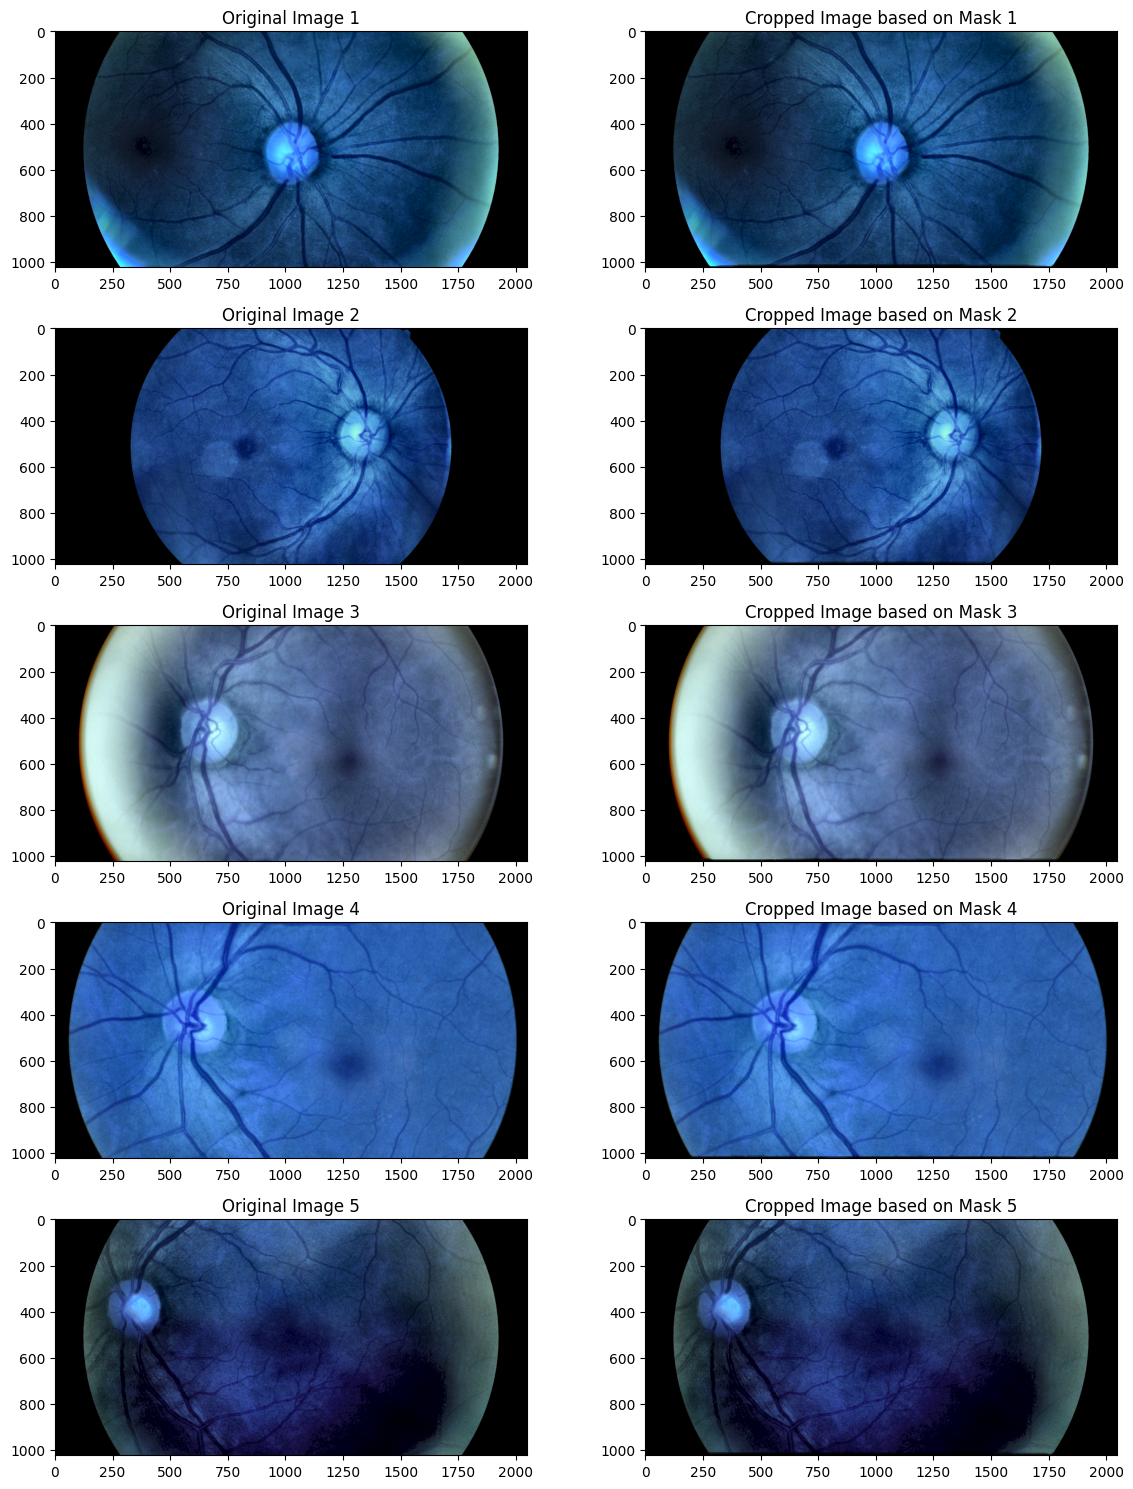

In [14]:
import matplotlib.pyplot as plt

# Display the first 5 cropped images and their corresponding masks
num_samples = 5

fig, axs = plt.subplots(num_samples, 2, figsize=(12, num_samples * 3))

for i in range(num_samples):
    # Display the original image and cropped image for the current sample
    axs[i, 0].imshow(new_images[i])
    axs[i, 0].set_title(f'Original Image {i+1}')

    axs[i, 1].imshow(cropped_images[i])
    axs[i, 1].set_title(f'Cropped Image based on Mask {i+1}')

plt.tight_layout()
plt.show()


MemoryError: Unable to allocate 36.0 TiB for an array with shape (1024, 2048, 3, 1024, 2048, 3) and data type uint8

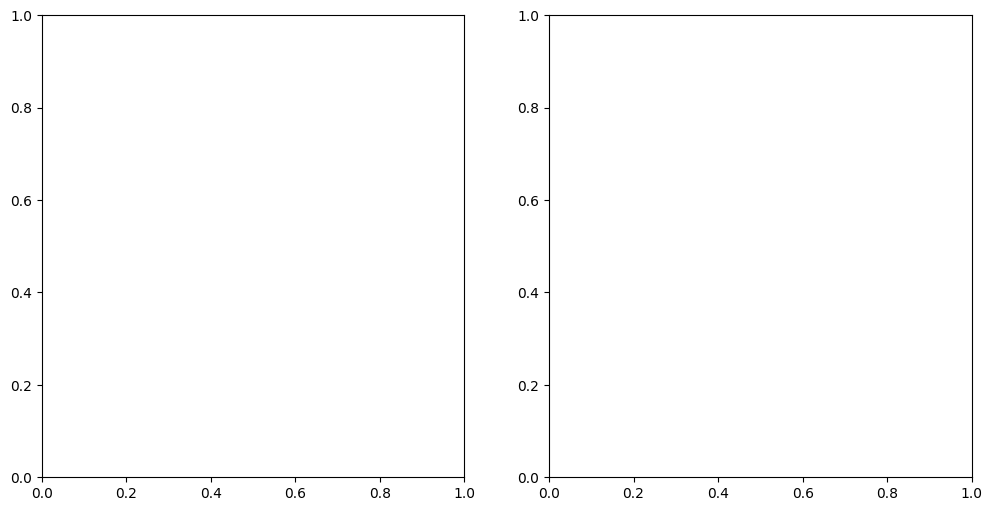

In [13]:
import matplotlib.pyplot as plt

# Display the first cropped image and its corresponding mask
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
for i in new_images:
    axs[0].imshow(new_images[i])
    axs[0].set_title('Original Image')

    # Display the cropped image using the predicted mask
    axs[1].imshow(cropped_images[0])
    axs[1].set_title('Cropped Image based on Mask')

    plt.show()


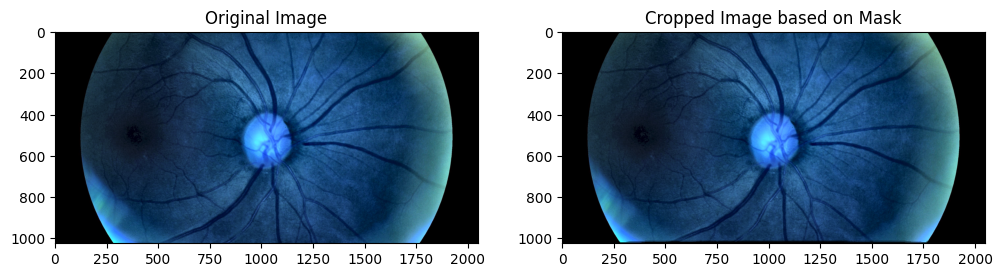

In [9]:
'''def crop_images_with_masks(images, masks):
    # Ensure images and masks have the same number of samples
    assert images.shape[0] == masks.shape[0]

    # Apply mask to each image
    cropped_images = []
    for i in range(images.shape[0]):
        # Convert mask to binary (0 or 1)
        binary_mask = (masks[i] > 0.5).astype(np.uint8)  # Assuming threshold of 0.5 for binary mask

        # Apply mask to image
        cropped_image = images[i] * np.expand_dims(binary_mask, axis=-1)

        # Append cropped image to list
        cropped_images.append(cropped_image)

    # Convert list of cropped images to numpy array
    cropped_images = np.array(cropped_images)

    return cropped_images
'''

def crop_images_with_masks(images, masks):
    # Ensure images and masks have the same number of samples
    assert images.shape[0] == masks.shape[0]

    # Apply mask to each image
    cropped_images = []
    for i in range(images.shape[0]):
        # Convert mask to binary (0 or 1)
        binary_mask = (masks[i] > 0.5).astype(np.uint8)  # Assuming threshold of 0.5 for binary mask

        # Ensure binary_mask has the same number of channels as the image (expand dimensions if necessary)
        if binary_mask.ndim == 2:  # Expand dimensions if mask is grayscale (single channel)
            binary_mask = np.expand_dims(binary_mask, axis=-1)  # Add a channel dimension

        # Apply mask to image
        cropped_image = images[i] * binary_mask

        # Append cropped image to list
        cropped_images.append(cropped_image)

    # Convert list of cropped images to numpy array
    cropped_images = np.array(cropped_images)

    return cropped_images

# Assuming 'predicted_masks' and 'new_images' are already defined and have appropriate shapes

# Crop out everything outside of the masks from the new images
cropped_images = crop_images_with_masks(new_images_normalized, predicted_masks)

# Display the first cropped image and its corresponding mask
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
axs[0].imshow(new_images[0])
axs[0].set_title('Original Image')

# Display the cropped image using the predicted mask
axs[1].imshow(cropped_images[0])
axs[1].set_title('Cropped Image based on Mask')

plt.show()


In [ ]:
## have to deal with relating the output of these masks eventually back to the original images,
#so keeping track of the filenames is important

## Use trained Gnet to make an cup and a disk mask on each image (all of these steps are in Diana's code)

In [ ]:
## FCN should export cropped images (write them to jpg so we have a saved step)

#make sure to keep the filenames exactly the same

## copy and paste the csv file with the classifications, or fix the code to be able to work with the images and csv files being in different folders

## calculate the CDR for each image, and determine whether it is above or below the threshold for glaucoma

## Validate the performance with the expert opinions provided in the dataset